In [1]:
# importing required libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.model_selection import RandomizedSearchCV, LeaveOneOut, GridSearchCV, cross_val_score, train_test_split
from sklearn.feature_selection import VarianceThreshold
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_curve, roc_auc_score
import scikitplot as skplt
from IPython.display import clear_output
from scipy.stats.stats import pearsonr
from matplotlib.colors import ListedColormap
from sklearn import neighbors
from sklearn.neural_network import MLPClassifier
from matplotlib import rc
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis

# *Data Cleaning*

In [2]:
df = pd.read_csv("preprocessed_Data_25Jan.csv").drop(columns = "Unnamed: 0")

In [3]:
X = df.iloc[:, 2:].values
y = df.iloc[:, 1].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 123)
scalar = StandardScaler().fit(X_train)
X_train = scalar.transform(X_train)
X_test = scalar.transform(X_test)

# *Define functions*

In [4]:
def Leave_one_out(Data, model, PrincipalComponent = False, LinearDiscriminant = False):
    X = Data.iloc[:, 2:].values
    #sel = VarianceThreshold()
    #sel.fit_transform(X)
    y = Data.iloc[:, 1].values
    loo = LeaveOneOut()
    #model = RandomForestClassifier()
    proba = []
    preds = []
    actuals = []
    pca = PCA(n_components=10)    
    for train_index, test_index in loo.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        scalar = MinMaxScaler().fit(X_train)
        X_train = scalar.transform(X_train)
        X_test = scalar.transform(X_test)

        if PrincipalComponent == True:
            pca = pca.fit(X_train)
            X_train = pca.transform(X_train)
            X_test = pca.transform(X_test)
        if LinearDiscriminant == True:
            lda = LinearDiscriminantAnalysis()
            lda.fit(X_train, y_train)
            X_train = lda.transform(X_train)
            X_test = lda.transform(X_test)

        model.fit(X_train, y_train)
        preds.append(model.predict(X_test)[0])
        actuals.append(y_test[0])
        proba.append(list(model.predict_proba(X_test)[0]))
    
    return preds, actuals, np.array(proba)

In [5]:
def Hyper_Tune(clf, param_grid):
    gs = GridSearchCV(estimator=clf, param_grid = param_grid,
                 cv = 3, scoring = 'accuracy', refit = True)
    return gs

# *Leave One Out*

 - LOO with K-NN

In [6]:
clf_KNN = neighbors.KNeighborsClassifier(5, weights="uniform")
Preds, Actuals, Scores = Leave_one_out(df, clf_KNN, PrincipalComponent=False, LinearDiscriminant=True)
print("LOO Accuracy: ", np.mean(Scores), "\n")
confusion = confusion_matrix(Actuals, Preds)
print("Confusion Matrix: ")
print(confusion, "\n")
print(classification_report(Actuals, Preds))

LOO Accuracy:  0.5982905982905983 

Confusion Matrix: 
[[46 25]
 [22 24]] 

              precision    recall  f1-score   support

           0       0.68      0.65      0.66        71
           1       0.49      0.52      0.51        46

    accuracy                           0.60       117
   macro avg       0.58      0.58      0.58       117
weighted avg       0.60      0.60      0.60       117



- LOO with SVM

In [102]:
# Linear SVM
clf = SVC(random_state=1, probability=True)
param_grid = {'C': [0.01, 0.1, 1, 10, 100, 1000],
              'kernel': ['linear']}
clf_lSVC = Hyper_Tune(clf, param_grid)
Preds, Actuals, lsvc_probs = Leave_one_out(df, clf_lSVC, PrincipalComponent=False, LinearDiscriminant=True)
print("LOO Accuracy: ", np.mean(Scores), "\n")
confusion = confusion_matrix(Actuals, Preds)
print("Confusion Matrix: ")
print(confusion, "\n")
print(classification_report(Actuals, Preds))

LOO Accuracy:  0.6068376068376068 

Confusion Matrix: 
[[47 24]
 [22 24]] 

              precision    recall  f1-score   support

           0       0.68      0.66      0.67        71
           1       0.50      0.52      0.51        46

    accuracy                           0.61       117
   macro avg       0.59      0.59      0.59       117
weighted avg       0.61      0.61      0.61       117



In [8]:
#non-linear SVM
clf = SVC(random_state=1, probability=True)
param_grid = {'C': [0.01, 0.1, 1, 10, 100, 1000],
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['rbf']}
clf_SVC = Hyper_Tune(clf, param_grid)
Preds, Actuals, Scores = Leave_one_out(df, clf_SVC, PrincipalComponent=False, LinearDiscriminant=True)
print("LOO Accuracy: ", np.mean(Scores), "\n")
confusion = confusion_matrix(Actuals, Preds)
print("Confusion Matrix: ")
print(confusion, "\n")
print(classification_report(Actuals, Preds))

LOO Accuracy:  0.5641025641025641 

Confusion Matrix: 
[[46 25]
 [26 20]] 

              precision    recall  f1-score   support

           0       0.64      0.65      0.64        71
           1       0.44      0.43      0.44        46

    accuracy                           0.56       117
   macro avg       0.54      0.54      0.54       117
weighted avg       0.56      0.56      0.56       117



- LOO with Random Forest

In [6]:
#clf_RF = RandomForestClassifier(n_estimators=100, criterion="entropy", random_state=1)
clf_RF = RandomForestClassifier(n_estimators=51, min_samples_split=10,
                                min_samples_leaf=2, max_features='sqrt',
                                max_depth=40, bootstrap=True,
                                random_state=1)
Preds, Actuals, Scores = Leave_one_out(df, clf_RF, PrincipalComponent=False, LinearDiscriminant=True)
print("LOO Accuracy: ", np.mean(Scores), "\n")
confusion = confusion_matrix(Actuals, Preds)
print("Confusion Matrix: ")
print(confusion, "\n")
print(classification_report(Actuals, Preds))

LOO Accuracy:  0.5 

Confusion Matrix: 
[[45 26]
 [22 24]] 

              precision    recall  f1-score   support

           0       0.67      0.63      0.65        71
           1       0.48      0.52      0.50        46

    accuracy                           0.59       117
   macro avg       0.58      0.58      0.58       117
weighted avg       0.60      0.59      0.59       117



- LOO with MLP

In [417]:
clf_MLP = MLPClassifier(solver='lbfgs', alpha=1e-4, hidden_layer_sizes=(12, 4), random_state=1)
Preds, Actuals, Scores = Leave_one_out(df, clf_MLP, PrincipalComponent=False, LinearDiscriminant=True)
print("LOO Accuracy: ", np.mean(Scores), "\n")
confusion = confusion_matrix(Actuals, Preds)
print("Confusion Matrix: ")
print(confusion, "\n")
print(classification_report(Actuals, Preds))

/home/mohammad/DataScience/Python/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


LOO Accuracy:  0.5811965811965812 

Confusion Matrix: 
[[45 26]
 [23 23]] 

              precision    recall  f1-score   support

           0       0.66      0.63      0.65        71
           1       0.47      0.50      0.48        46

    accuracy                           0.58       117
   macro avg       0.57      0.57      0.57       117
weighted avg       0.59      0.58      0.58       117



- Ensemble Voting Model

In [21]:
clf_ensemble = VotingClassifier(
    estimators=[('Random Forest', clf_RF), ('K-NN', clf_KNN), ('SVC', clf_lSVC)],
    voting='hard')
Preds, Actuals, Scores = Leave_one_out(df, clf_ensemble, PrincipalComponent=False, LinearDiscriminant=True)
print("LOO Accuracy: ", np.mean(Scores), "\n")
confusion = confusion_matrix(Actuals, Preds)
print("Confusion Matrix: ")
print(confusion, "\n")
print(classification_report(Actuals, Preds))

LOO Accuracy:  0.6068376068376068 

Confusion Matrix: 
[[47 24]
 [22 24]] 

              precision    recall  f1-score   support

           0       0.68      0.66      0.67        71
           1       0.50      0.52      0.51        46

    accuracy                           0.61       117
   macro avg       0.59      0.59      0.59       117
weighted avg       0.61      0.61      0.61       117



# *Neural Networks*
- Multi Layer Perceptron (MLP)

In [401]:
clf_MLP = MLPClassifier(solver='lbfgs', alpha=1e-4, hidden_layer_sizes=(12, 4), random_state=1)
clf_MLP.fit(X_train, y_train)
print("Score on test: ", clf_MLP.score(X_test, y_test), "\n")
confusion = confusion_matrix(y_test, clf_MLP.predict(X_test))
print("Confusion Matrix: ")
print(confusion)
print(classification_report(y_test, clf_MLP.predict(X_test)))

Score on test:  0.875 

Confusion Matrix: 
[[15  3]
 [ 0  6]]
              precision    recall  f1-score   support

           0       1.00      0.83      0.91        18
           1       0.67      1.00      0.80         6

    accuracy                           0.88        24
   macro avg       0.83      0.92      0.85        24
weighted avg       0.92      0.88      0.88        24



In [52]:
scalar = MinMaxScaler().fit_transform(X_test)

lda = LinearDiscriminantAnalysis()
X_ld = lda.fit_transform(X_test, y_test)

In [109]:
#y_pred_proba = clf_lSVC.predict_proba(X_ld)[:, 1]
y_pred_proba = lsvc_probs[:, 1]
fpr, tpr, _ = roc_curve(y, y_pred_proba)

In [110]:
auc = roc_auc_score(y, y_pred_proba)

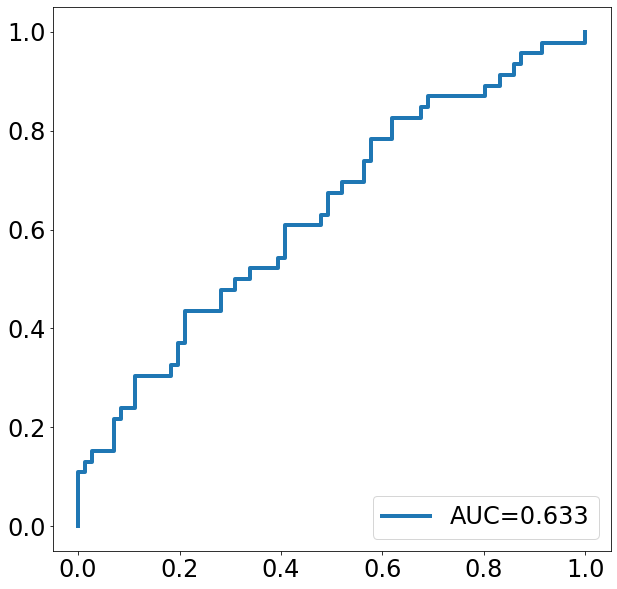

In [123]:
rc('figure', figsize=(10,10))
font = {'family' : 'sans',
        'weight' : 'normal',
        'size'   : 24}
rc('font', **font)
rc('lines', linewidth=4)
plt.plot(fpr,tpr,label="AUC="+str(auc)[:5])
plt.legend(loc=4)
plt.savefig("/home/mohammad/Programs/ADHD_Figs/ROC_LSVC.png")
plt.show()

In [125]:
y

array([0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0,
       1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0,
       1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0,
       0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0,
       1, 0, 1, 0, 0, 1, 1])

In [124]:
y_pred_proba

array([9.99998610e-01, 3.19009845e-03, 1.38179596e-04, 1.50365256e-03,
       7.21226129e-01, 9.70629824e-01, 2.26043624e-02, 1.61987403e-01,
       6.55648276e-06, 1.02887663e-03, 1.74955881e-04, 1.03810294e-03,
       9.16861898e-02, 2.15671095e-03, 1.29736898e-01, 8.80446321e-01,
       9.99990154e-01, 6.13093580e-01, 1.50351841e-03, 7.31982226e-03,
       2.90091488e-02, 1.41009011e-01, 1.23508559e-03, 7.09994666e-03,
       9.99999018e-01, 6.46806973e-01, 9.62778643e-03, 9.90773152e-01,
       4.33956927e-02, 1.96542507e-02, 5.43595546e-06, 9.71108202e-03,
       9.21652084e-04, 5.89045888e-01, 5.36190699e-04, 9.95807897e-01,
       9.99999413e-01, 4.36868504e-02, 7.06416074e-02, 9.95128665e-01,
       3.96702235e-01, 3.39397590e-04, 2.61910221e-01, 3.56891217e-02,
       3.84024831e-01, 4.07197756e-01, 9.80543445e-01, 1.22529178e-03,
       1.63755442e-03, 4.31956348e-01, 1.18595971e-03, 8.90388409e-01,
       8.48175625e-01, 1.07745515e-02, 9.99987122e-01, 9.97131478e-01,
      